# MNIST classification with Qiskit

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import array_to_latex
from qiskit.quantum_info.operators import Operator, Pauli

import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.quantum.qubit import matrix_to_qubit
from scipy.optimize import minimize
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
def sim_state(qc, disp=True):
    '''
    量子回路qcの量子状態を取得する。

    Args:
        qc (QuantumCircuit): 量子回路
        disp (Bool): Trueにするとketベクトルの線型結合の形で量子状態表記を得る。
    '''
    sim = Aer.get_backend('statevector_simulator')
    qc = transpile(qc, backend=sim)
    res = sim.run(qc).result()
    state = res.data()['statevector']
    if disp:
        ket = matrix_to_qubit(np.array(state)[:, np.newaxis])
        print(ket)
    return state

In [3]:
def mag_exp(qc, n):
    '''
    引数に与えられた期待値を計算する。

    Args:
        qc (QuantumCircuit): 量子回路
        n (int): qubit数

    Returns:
        y (float): 期待値
    '''
    state = sim_state(qc, disp=False)
    op = Operator(np.zeros([2**n, 2**n]))
    for k in range(n):
        op_str = ''
        for l in range(n):
            if l == k:
                op_str += 'Z'
            else:
                op_str += 'I'
        op += Operator(Pauli(op_str))
        
    y = state.expectation_value(op)/n
    return y

In [4]:
def U_in(x, n):
    '''
    Args:
        x データ。-1〜1に規格化された
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)

    angle = np.arcsin(x)
    qc.rx(angle, qr)
    
    U_in = qc.to_gate()
    U_in.name = 'U_in'

    return U_in

In [5]:
def QCLinput(x, n):
    '''
    量子回路を作るための関数
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)
    qc.append(U_in(x, n), qr)
    return qc

In [6]:
def U_rot(n, params):
    '''
    Args:
        n (int):
        params (list): rx: 0, 1, 2, ..., n-1
                       ry: n, n+1, n+2, ..., n+n-1
                       rz: 2n, 2n+1, 2n+2, ..., 2n+n-1
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)
    for k in range(n):
        qc.rx(params[k], qr[k])
        qc.ry(params[n+k], qr[k])
        qc.rz(params[2*n+k], qr[k])
    Urot = qc.to_gate()
    Urot.name = 'Urot'
    return Urot

In [7]:
def U_ent(n):
    '''
    entanglement
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)

    if n > 1:
        for k in range(n-1):
            qc.cz(qr[k], qr[k+1])
        qc.cz(qr[n-1], qr[0])

    Uent = qc.to_gate()
    Uent.name = 'U_ent'
    return Uent    

In [8]:
# 回帰用データでQNN作成
# まずは、ランダムに生成したparamをそのまま用いたQNNではどのような出力をするかの実験

n = 3
x_series = np.linspace(-1, 1, 100)
y_series = []
depth = 3
params = np.random.rand(3*n*depth)*2*np.pi

for x in x_series:
    # 入力層
    qc = QCLinput(x, n)
    qr = qc.qubits
    # 中間層
    for k in range(depth):
        qc.append(U_ent(n), qr)
        qc.append(U_rot(n, params[k*3*n:(k+1)*3*n]), qr)
    # 出力層
    y = mag_exp(qc, n)
    y_series.append(y)

In [9]:
qc.draw()

┌───────┐┌────────┐┌───────┐┌────────┐┌───────┐┌────────┐┌───────┐
q793_0: ┤0      ├┤0       ├┤0      ├┤0       ├┤0      ├┤0       ├┤0      ├
        │       ││        ││       ││        ││       ││        ││       │
q793_1: ┤1 U_in ├┤1 U_ent ├┤1 Urot ├┤1 U_ent ├┤1 Urot ├┤1 U_ent ├┤1 Urot ├
        │       ││        ││       ││        ││       ││        ││       │
q793_2: ┤2      ├┤2       ├┤2      ├┤2       ├┤2      ├┤2       ├┤2      ├
        └───────┘└────────┘└───────┘└────────┘└───────┘└────────┘└───────┘

/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


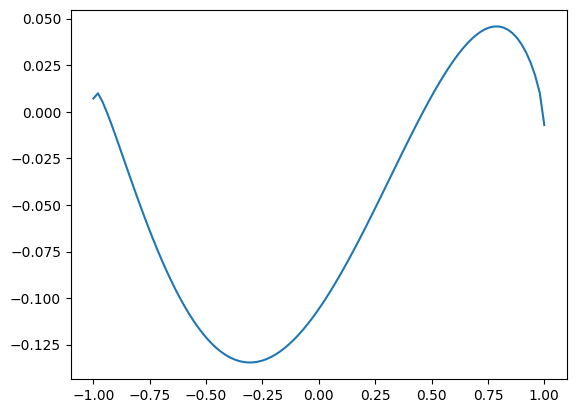

In [10]:
plt.plot(x_series, y_series)
plt.show()

#### 学習

In [11]:
# 真値
func = lambda x: 0.5*x**3

In [12]:
ntrain = 10

# 訓練データ（-1〜1）
xtrain = 2*np.random.rand(ntrain)-1
# 教師データ
ytrain = func(xtrain)

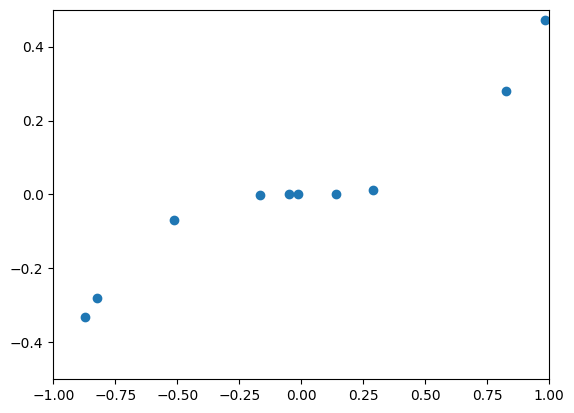

In [13]:
plt.scatter(xtrain, ytrain)
plt.xlim([-1, 1])
plt.ylim([-0.5, 0.5])
plt.show()

In [14]:
def cost_func(params):
    '''
    コスト関数
    '''
    cost_total = 0
    for k in range(ntrain):
        x = xtrain[k]
        qc = QCLinput(x, n)
        qr = qc.qubits
        for d in range(depth):
            qc.append(U_ent(n), qr)
            qc.append(U_rot(n, params[d*3*n:(d+1)*3*n]), qr)
        y = mag_exp(qc, n)
        cost = 0.5*(ytrain[k]-y)**2
        cost_total += cost
    cost_total /= ntrain
    return cost_total

In [15]:
# 勾配を使わない、探索的な最適化方法
result =  minimize(cost_func, params, method='COBYLA', options={'maxiter': 50})

/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
/hom

In [16]:
# 0に近いほうが良い。
result.fun

0.000633861811974053

In [17]:
result.x

array([2.49071708, 6.65046411, 5.57605119, 5.47444311, 2.4780659 ,
       4.77166383, 2.31746287, 5.92549056, 6.0292418 , 7.1065618 ,
       1.00056517, 5.57052676, 2.12822434, 1.91341474, 1.82173216,
       1.25770624, 2.36783451, 1.83701908, 3.10681556, 2.9956318 ,
       3.20454443, 5.04574829, 5.97472436, 3.19123889, 2.55823768,
       1.7590029 , 0.11366578])

In [18]:
# 学習済みのパラメータを使って推論
y_series = []
params = result.x

for x in x_series:
    qc = QCLinput(x, n)
    qr = qc.qubits
    for d in range(depth):
        qc.append(U_ent(n), qr)
        qc.append(U_rot(n, params[d*3*n:(d+1)*3*n]), qr)
    y = mag_exp(qc, n)
    y_series.append(y)

In [19]:
y_correct = func(x_series)

/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/anaconda3/envs/quantum_q_p/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


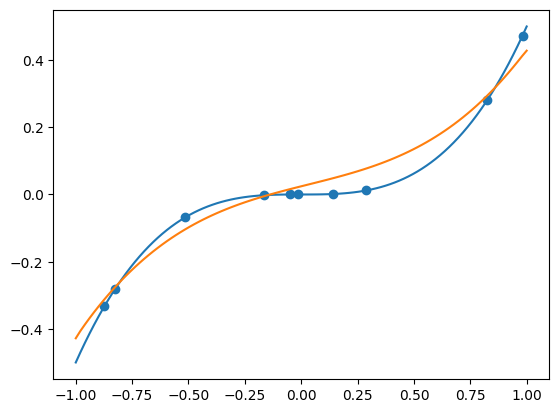

In [20]:
plt.scatter(xtrain, ytrain)
plt.plot(x_series, y_correct)
plt.plot(x_series, y_series)
plt.show()